In [154]:
import pandas as pd
import plotly.express as px
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tinyshift.stats import BootstrapBCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tinycp.regressor import ConformalizedRegressor
from tinycp.plot import plot_prediction_intervals
from tinyshift.modelling import FeatureResidualizer, filter_features_by_vif, RobustGaussianScaler
from tinyshift.plot import corr_barplot, corr_heatmap

# EDA

## Feature Selection
- avgAnnCount: Mean number of reported cases of cancer diagnosed annually
    - The diagnosis could demonstrate people having a minimal medical treatment.
- incidenceRate: Mean per capita (100,000) cancer diagnoses
    - The diagnosis could demonstrate people having a minimal medical treatment.
- PctPrivateCoverage: Percent of county residents with private health coverage 
    - People that has private health insurance can have a better medical treatment.
- PctPublicCoverage: Percent of county residents with government-provided health coverage 
    - An urge of public health system usage could be a indicative of less people can afford a private health coverage.
- PctBachDeg25_Over: Percent of county residents ages 25 and over highest education attained: bachelor’s degree 
	- Higher education can be an indicative of more income.
- PercentMarried: Percent of county residents who are married 
	- Residents who are married can indicate two incomes in the family, possibly affording the private coverage.
- binnedInc: Median income per capita binned by decile
	- what would I do with this column? Discrete?
- povertyPercent: Percent of populace in poverty
    - Less chance of getting any treatment
- medianIncome: Median income per county
    - Higher median income can be an indicative of less inequality 
- MedianAge: Median age of female county residents 
	- An elderly population may indicate difficulty in facing more severe cancer
- PctWhite
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctBlack
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctAsian
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctOtherRace
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- avgDeathsPerYear
    - Number of reported mortalities due to cancer to "adjust" the estimation
- popEst2015
    - Estimate population to "adjust" the estimation

In [155]:
df = pd.read_csv("./data/cancer_reg.csv", encoding='iso-8859-1')

In [156]:
#df = pd.get_dummies(df, columns=['binnedInc'], dtype=int) # Explode. One-hot encoding for binnedInc

In [157]:
df = df[df['MedianAge'] <= 90]

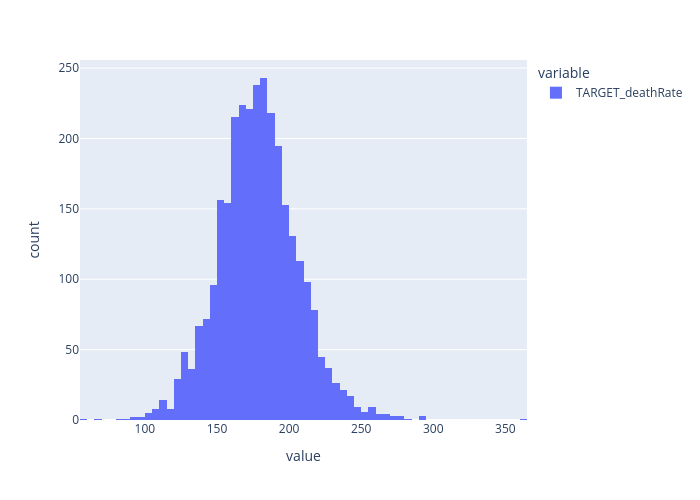

In [158]:
fig = px.histogram(df["TARGET_deathRate"])
fig.show("png")

In [159]:
df["TARGET_deathRate"].var() > df["TARGET_deathRate"].mean()

True

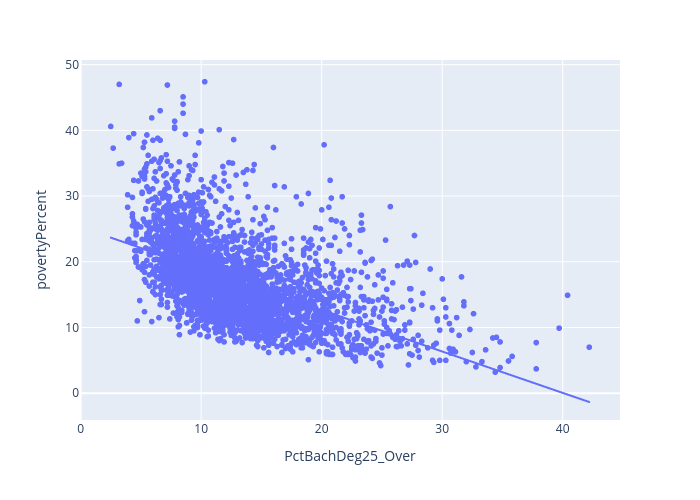

In [160]:
px.scatter(df, x='PctBachDeg25_Over', y='povertyPercent', trendline='ols').show("png")

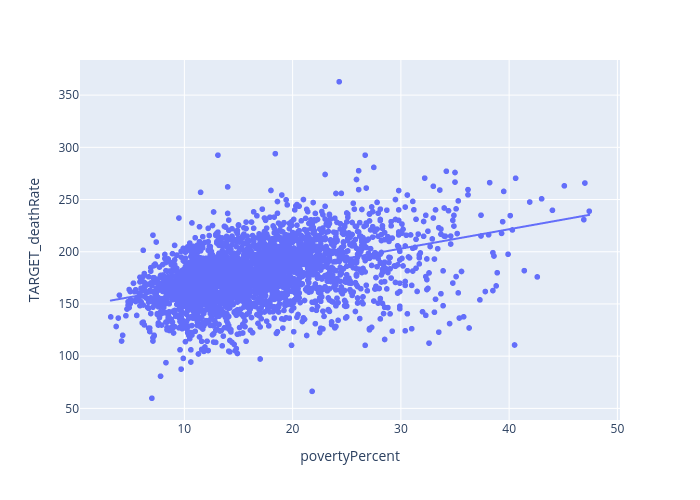

In [161]:
px.scatter(df, x='povertyPercent', y='TARGET_deathRate', trendline='ols').show("png")

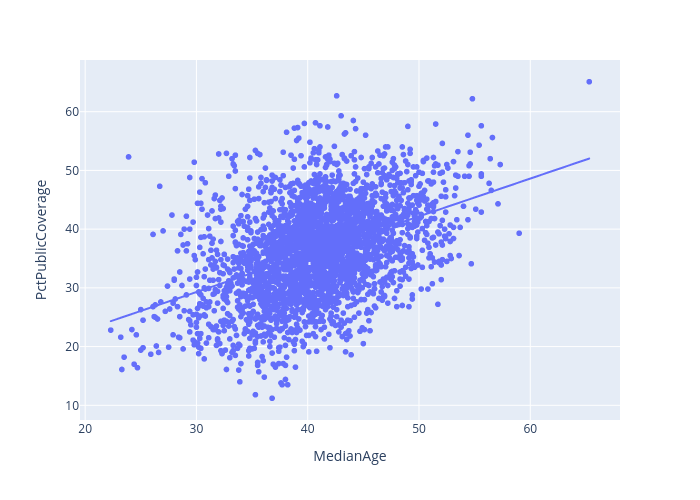

In [162]:
px.scatter(df, x='MedianAge', y='PctPublicCoverage', trendline='ols').show("png")

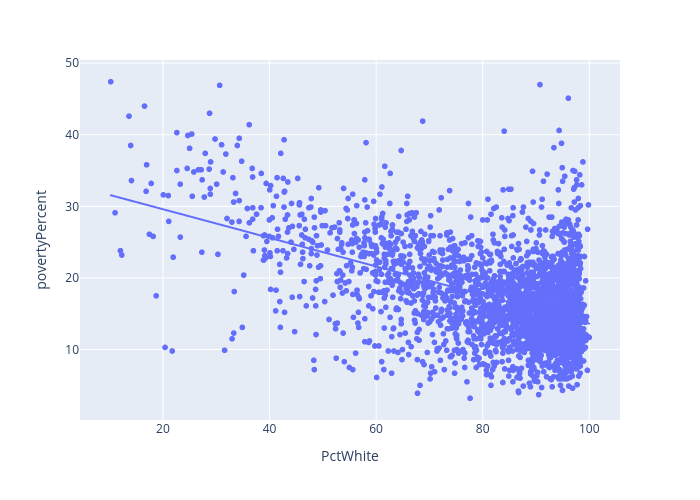

In [163]:
px.scatter(df, x='PctWhite', y='povertyPercent', trendline='ols').show("png")

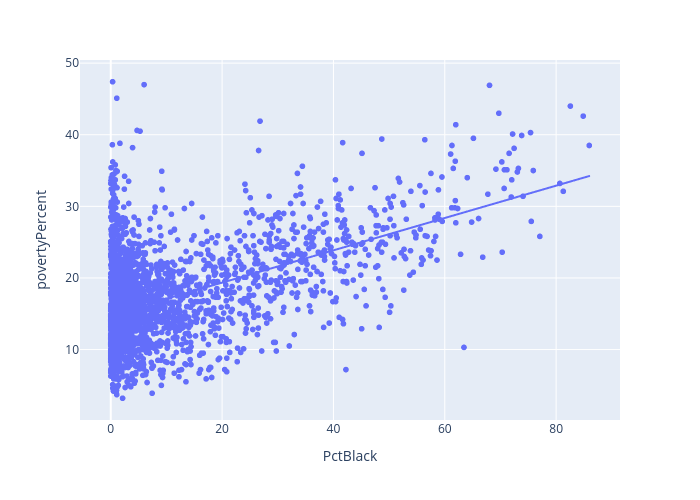

In [164]:
px.scatter(df, x='PctBlack', y='povertyPercent', trendline='ols').show("png")

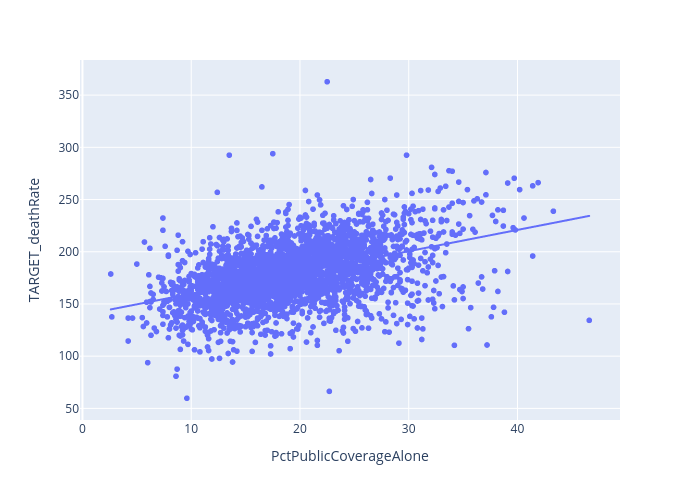

In [165]:
px.scatter(df, x='PctPublicCoverageAlone', y='TARGET_deathRate', trendline='ols').show("png")

## Percentage of Total of NaN Data for Each Column

In [166]:
df.isnull().sum() / len(df)

avgAnnCount                0.000000
avgDeathsPerYear           0.000000
TARGET_deathRate           0.000000
incidenceRate              0.000000
medIncome                  0.000000
popEst2015                 0.000000
povertyPercent             0.000000
studyPerCap                0.000000
binnedInc                  0.000000
MedianAge                  0.000000
MedianAgeMale              0.000000
MedianAgeFemale            0.000000
Geography                  0.000000
AvgHouseholdSize           0.000000
PercentMarried             0.000000
PctNoHS18_24               0.000000
PctHS18_24                 0.000000
PctSomeCol18_24            0.750083
PctBachDeg18_24            0.000000
PctHS25_Over               0.000000
PctBachDeg25_Over          0.000000
PctEmployed16_Over         0.049387
PctUnemployed16_Over       0.000000
PctPrivateCoverage         0.000000
PctPrivateCoverageAlone    0.199536
PctEmpPrivCoverage         0.000000
PctPublicCoverage          0.000000
PctPublicCoverageAlone     0

In [167]:
df = df.drop(columns=["PctSomeCol18_24", "PctPrivateCoverageAlone"])

## CI

In [168]:
bca = BootstrapBCA()
bca.compute_interval(df["PctEmployed16_Over"].dropna(), confidence_level=0.95, statistic=np.mean, n_resamples=1000)

(53.82614569603778, 54.43873685962987)

In [169]:
df["PctEmployed16_Over"] = df["PctEmployed16_Over"].fillna(np.ceil(df["PctEmployed16_Over"].mean()))

In [170]:
features_in = [
"avgAnnCount",
"PctPrivateCoverage",
"PctPublicCoverage",
"PctBachDeg25_Over",
"PercentMarried",
"incidenceRate",
"povertyPercent",
"MedianAge",
"medIncome",
"PctWhite",
"PctBlack",
"PctAsian",
"PctOtherRace",
"avgDeathsPerYear",
]
target = "TARGET_deathRate"

# Modelling

In [171]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [172]:
scaler = RobustGaussianScaler()
residualizer = FeatureResidualizer()

In [173]:
df_train = df_train.astype({x: float for x in features_in})
df_test = df_test.astype({x: float for x in features_in})

In [174]:
df_train.loc[:, features_in]  = scaler.fit_transform(df_train[features_in], winsorize_method="mad")
df_test.loc[:, features_in]  = scaler.transform(df_test[features_in])

In [175]:
df_train.loc[:, features_in] = residualizer.fit_transform(df_train[features_in], corrcoef=0.70)
df_test.loc[:, features_in] = residualizer.transform(df_test[features_in])

In [176]:
model = LinearRegression()

In [177]:
model.fit(df_train[features_in], df_train[target])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [178]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train[target].std()
    return std_coef

In [179]:
model.feature_importance_ = standardize_coefficients(model, df_train)
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)
feature_importance

,feature,std_coef
0,incidenceRate,0.392672
1,PctPublicCoverage,0.199411
2,avgDeathsPerYear,0.165997
3,PctBlack,0.070763
4,povertyPercent,0.038117
5,PercentMarried,-0.002013
6,PctWhite,-0.012160
7,MedianAge,-0.043418
8,PctAsian,-0.054904
9,medIncome,-0.095773


In [180]:
y_pred = model.predict(df_test[features_in])
mse = mean_squared_error(df_test[target], y_pred)
r2 = r2_score(df_test[target], y_pred)
mse, r2

(422.61916876449334, 0.46900799287543815)

In [181]:
mask = filter_features_by_vif(df_train[features_in]).tolist()
filtered_features = np.array(features_in)[mask].tolist()

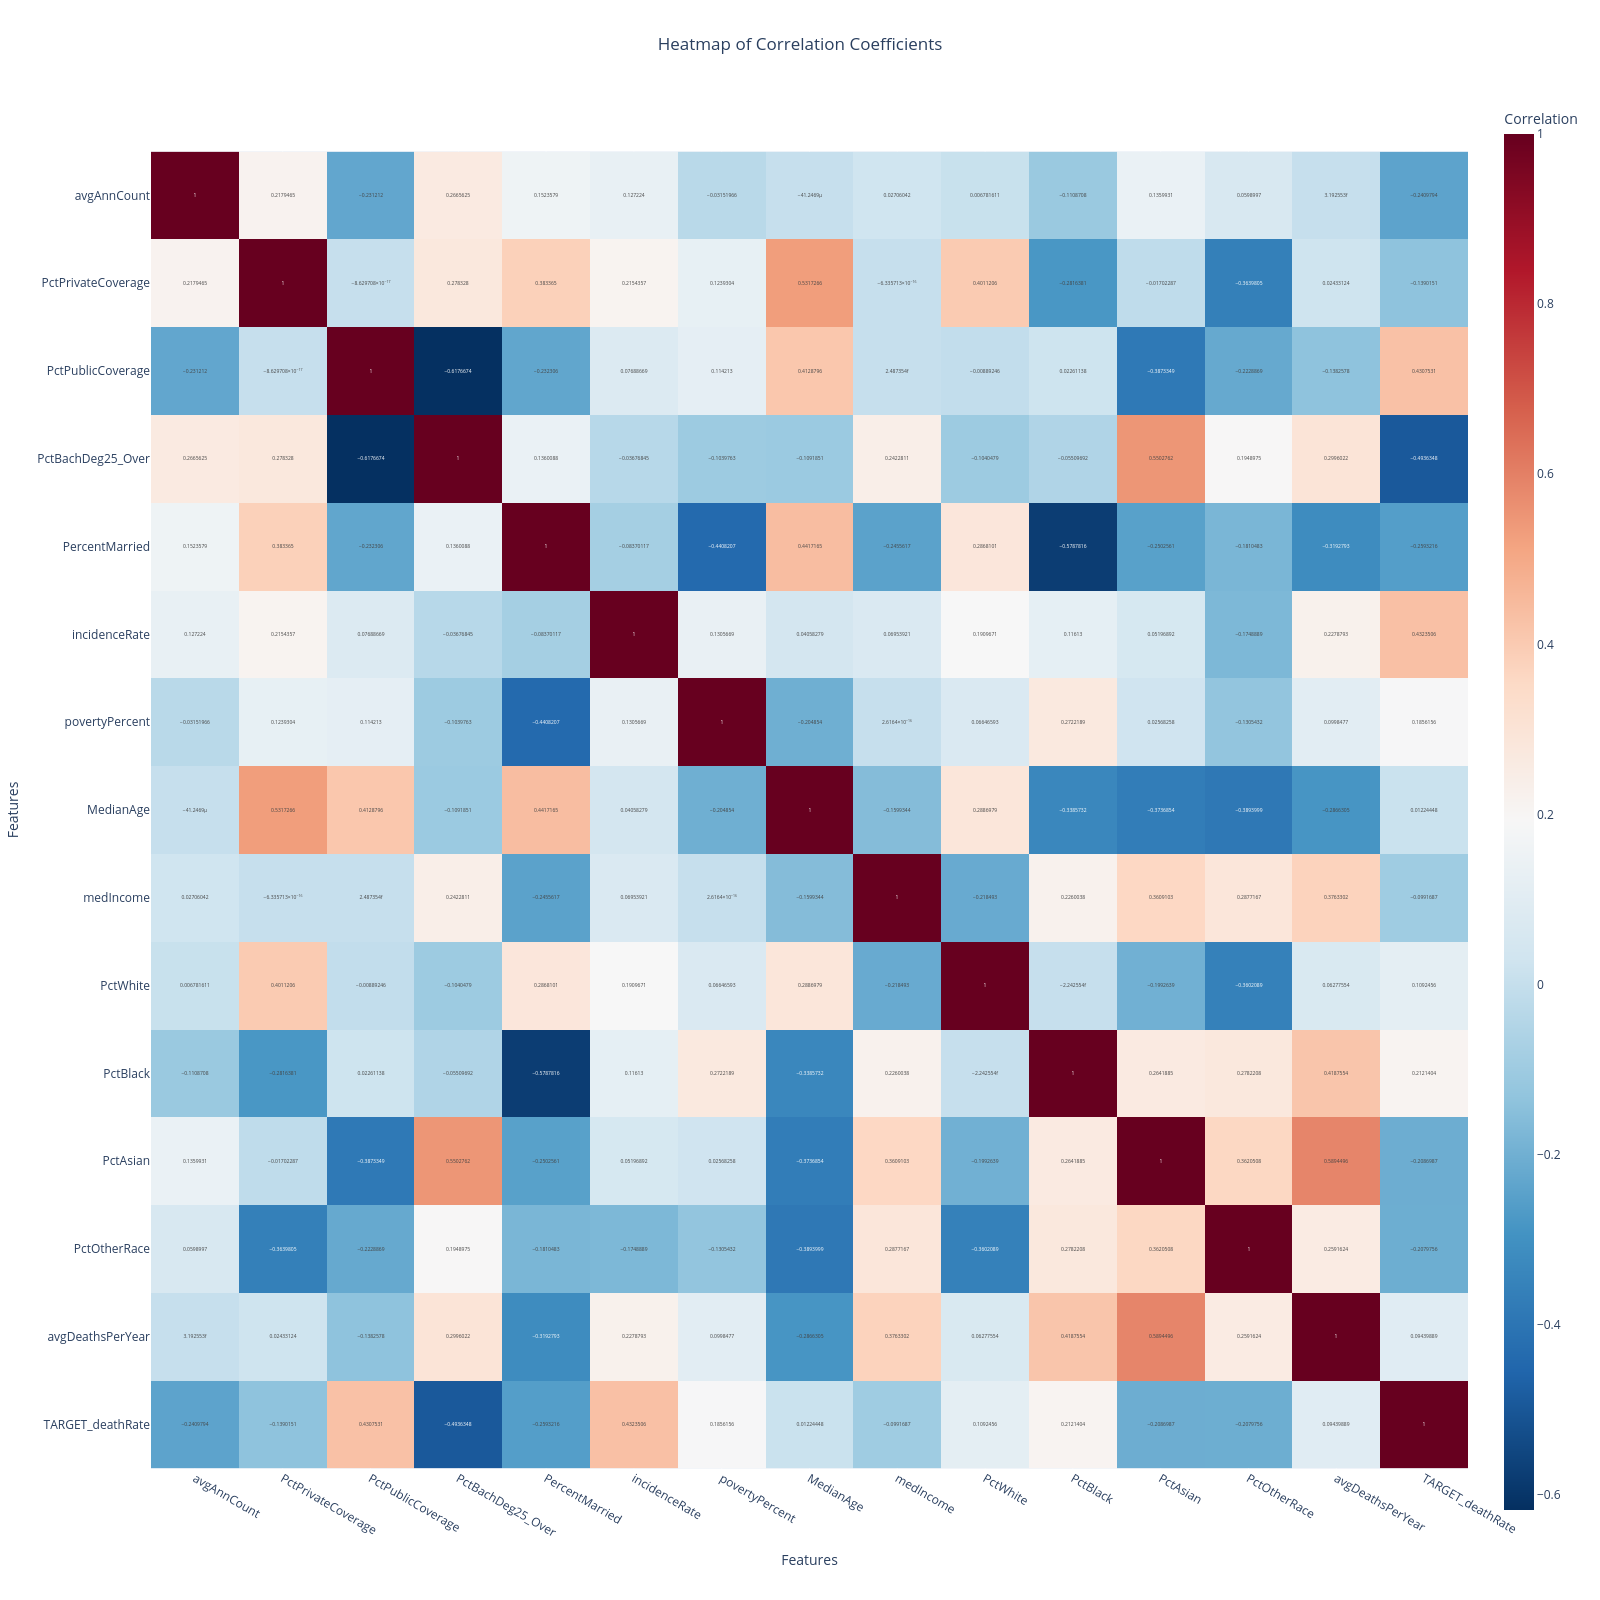

In [182]:
corr_heatmap(df_train[filtered_features + ["TARGET_deathRate"]], fig_type="png")

In [183]:
def generate_vif_dataframe(df, features):

    def _vif_rank(data):
        if 1 < data < 5:
            return "Low"
        elif 5 <= data < 15:
            return "Moderate"
        elif 15 <= data < 20:
            return "High"
        elif 20 <= data < 30:
            return "Very High"
        return "Extreme"
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(df[features].shape[1])]
    vif_data["Tolerance"] = 1 / vif_data["VIF"]
    vif_data["VIF Rank"] = vif_data["VIF"].apply(_vif_rank)
    return vif_data

In [184]:
generate_vif_dataframe(df_train, features_in).sort_values(by="Tolerance")

,feature,VIF,Tolerance,VIF Rank
2,PctPublicCoverage,2.959012,0.337951,Low
4,PercentMarried,2.896515,0.345243,Low
7,MedianAge,2.883905,0.346752,Low
3,PctBachDeg25_Over,2.786676,0.358850,Low
1,PctPrivateCoverage,2.687281,0.372123,Low
11,PctAsian,2.366272,0.422606,Low
13,avgDeathsPerYear,2.114236,0.472984,Low
10,PctBlack,1.908165,0.524064,Low
9,PctWhite,1.704041,0.586840,Low
6,povertyPercent,1.662670,0.601442,Low


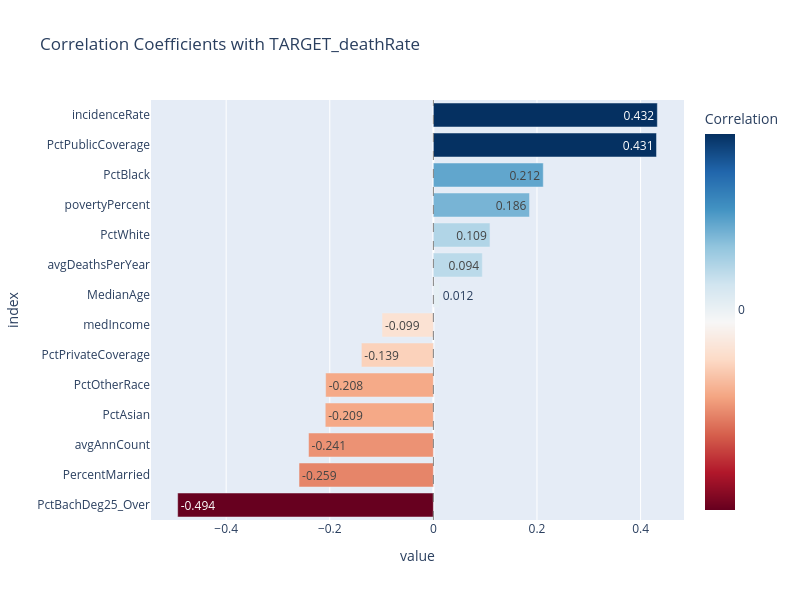

In [185]:
corr_barplot(df_train[filtered_features], df_train['TARGET_deathRate'], fig_type="png")

In [186]:
model = LinearRegression()

In [187]:
model.fit(df_train[filtered_features], df_train[target])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [188]:
y_pred = model.predict(df_test[filtered_features])
y_test = df_test[target]

In [189]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse, r2

(422.61916876449334, 0.46900799287543815)

<Axes.ArtistList of 2 lines>

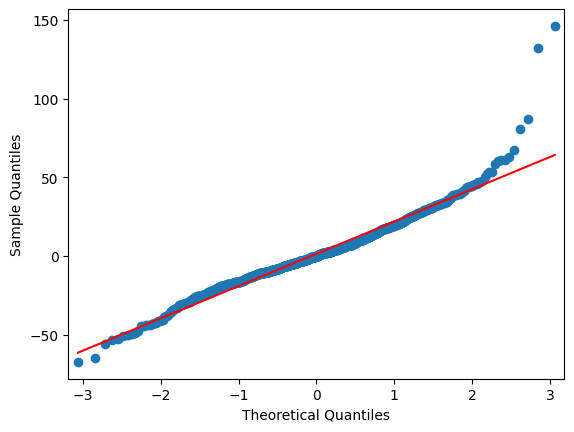

In [190]:
residuals = y_test - y_pred
qqplot(residuals, line='s').gca().lines

In [191]:
# Goldfeld-Quandt test
gq_test = het_goldfeldquandt(residuals, df_test[filtered_features])
print("Goldfeld-Quandt test:")
print(f"F-stat: {gq_test[0]}, p-value: {gq_test[1]}\n")

Goldfeld-Quandt test:
F-stat: 0.9371965780895783, p-value: 0.7514503703439862



In [192]:
dw = durbin_watson(residuals)
print(f"Durbin-Watson statistic:", dw)

# DW ≈ 2: No autocorrelation.
# DW < 2: Possible positive autocorrelation.
# DW > 2: Possible negative autocorrelation.

Durbin-Watson statistic: 1.9457370977734048


In [193]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train['TARGET_deathRate'].std()
    return std_coef

In [194]:
model.feature_importance_ = standardize_coefficients(model, df_train)

In [195]:
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)
feature_importance

,feature,std_coef
0,incidenceRate,0.392672
1,PctPublicCoverage,0.199411
2,avgDeathsPerYear,0.165997
3,PctBlack,0.070763
4,povertyPercent,0.038117
5,PercentMarried,-0.002013
6,PctWhite,-0.012160
7,MedianAge,-0.043418
8,PctAsian,-0.054904
9,medIncome,-0.095773


In [196]:
X = sm.add_constant(df_train[filtered_features]) # add intercept
y = df_train[target]
model_sm = sm.OLS(y, X).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       TARGET_deathRate   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     157.3
Date:                Mon, 04 Aug 2025   Prob (F-statistic):          5.16e-314
Time:                        15:49:56   Log-Likelihood:                -9235.1
No. Observations:                2111   AIC:                         1.850e+04
Df Residuals:                    2096   BIC:                         1.858e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                178.3220      0.420    424.828      0.000     177.499     179.145
avgAnnCount           -5.8954      0.804     -7.333      0.000      -7.472      -4.319
PctPrivateCoverage    -5.1950      1.015     -5.116      0.000      -7.186      -3.204
PctPublicCoverage      5.4873      0.722      7.600      0.000       4.071       6.903
PctBachDeg25_Over     -7.1482      0.701    -10.201      0.000      -8.522      -5.774
PercentMarried        -0.0554      0.714     -0.078      0.938      -1.456       1.346
incidenceRate         10.8055      0.464     23.302      0.000       9.896      11.715
povertyPercent         1.8669      0.963      1.938      0.053      -0.022       3.756
MedianAge             -1.1948      0.713     -1.676      0.094      -2.593       0.203
medIncome             -6.6244      1.242     -5.332      0.000      -9.061      -4.188
PctWhite              -0.5004      0.819     -0.611      0.541      -2.107       1.107
PctBlack               1.9472      0.580      3.358      0.001       0.810       3.084
PctAsian              -1.5108      0.646     -2.340      0.019      -2.777      -0.245
PctOtherRace          -3.1778      0.537     -5.921      0.000      -4.230      -2.125
avgDeathsPerYear       4.5679      0.610      7.484      0.000       3.371       5.765
==============================================================================
Omnibus:                      171.275   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.083
Skew:                           0.293   Prob(JB):                    3.50e-153
Kurtosis:                       5.764   Cond. No.                         5.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
p_values = model_sm.pvalues
p_values = p_values[p_values < 0.10].drop("const")
filtered_features = p_values.index

## Multiple Linear Regression: Dividing by binnedInc

In [205]:
def generate_regression_models_by_binned_inc(df, features,target='TARGET_deathRate', binned_col='binnedInc'):
    """
    Create a multiple linear regression model for each bin of the binned income column.
    """
    models = {}
    for bin_value in df[binned_col].unique():
        df_bin = df[df[binned_col] == bin_value]
        model = LinearRegression()
        models[bin_value] = model.fit(df_bin[features], df_bin[target])
    return models


In [206]:
multi_models = generate_regression_models_by_binned_inc(df_train, filtered_features)

In [207]:
def evaluate_regression_models(models, df_test, features, target='TARGET_deathRate', binned_col='binnedInc'):
    """
    Evaluate multiple regression models on the test set.
    """
    results = {}
    for bin_value in models:
        df_bin = df_test[df_test[binned_col] == bin_value]
        y_pred = models[bin_value].predict(df_bin[features])
        y_test = df_bin[target]
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[bin_value] = {'mse': mse, 'r2': r2}
    return pd.DataFrame(results).T

In [208]:
evaluate_regression_models(multi_models, df_test, filtered_features)

,mse,r2
"(54545.6, 61494.5]",301.675011,0.214502
"[22640, 34218.1]",135.942898,0.872212
"(42724.4, 45201]",465.800167,0.288654
"(48021.6, 51046.4]",299.866915,0.290957
"(51046.4, 54545.6]",273.608826,0.326622
"(40362.7, 42724.4]",486.092897,0.225920
"(61494.5, 125635]",475.936399,0.277453
"(45201, 48021.6]",487.315659,0.289271
"(37413.8, 40362.7]",697.858342,0.354176
"(34218.1, 37413.8]",389.444768,0.360354


In [209]:
def generate_qqplot_by_binned_inc(models, df_test, features):
    """
    Generate QQ plots for the residuals of each regression model.
    """
    binned_col = 'binnedInc'
    for bin_value in models:
        df_bin = df_test[df_test[binned_col] == bin_value]
        y_pred = models[bin_value].predict(df_bin[features])
        y_test = df_bin['TARGET_deathRate']
        residuals = y_test - y_pred
        qqplot(residuals, line='s').gca().lines
        plt.title(f'QQ Plot for {binned_col} = {bin_value}')
        plt.show()

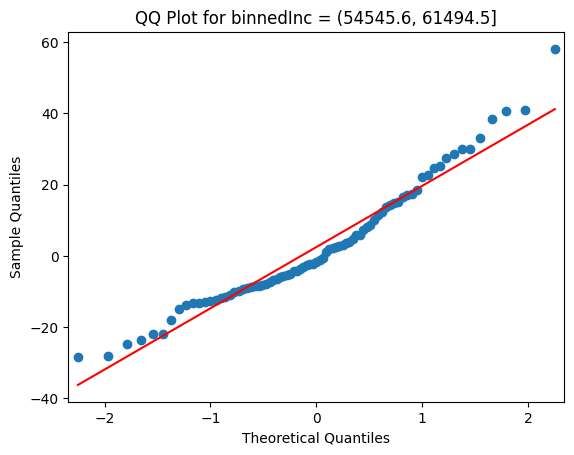

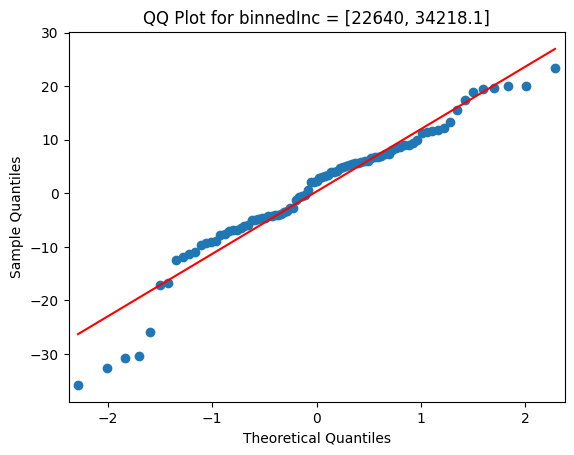

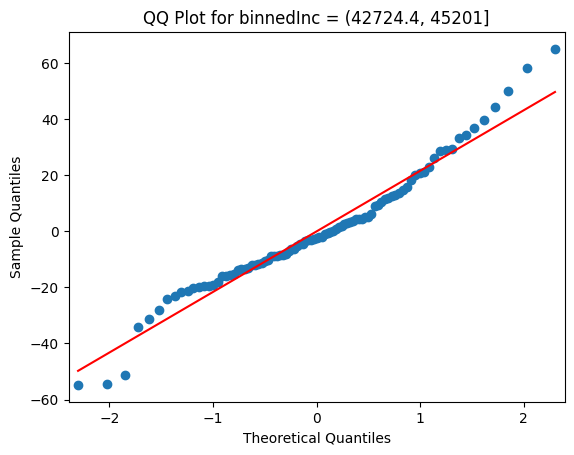

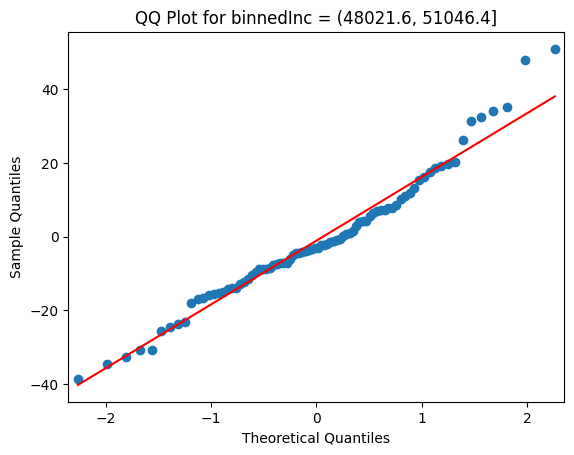

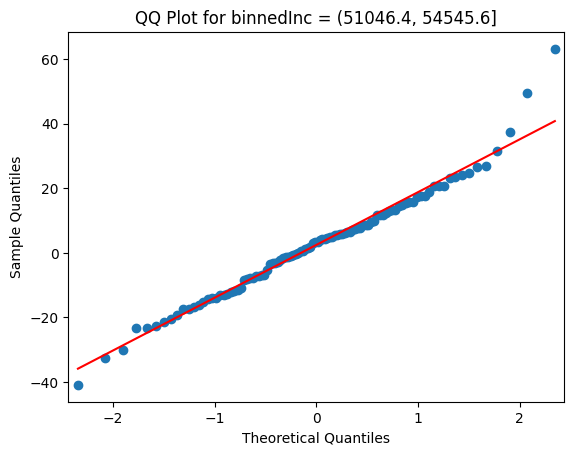

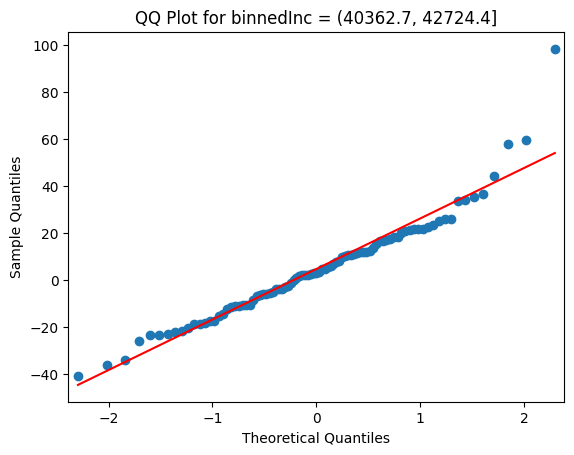

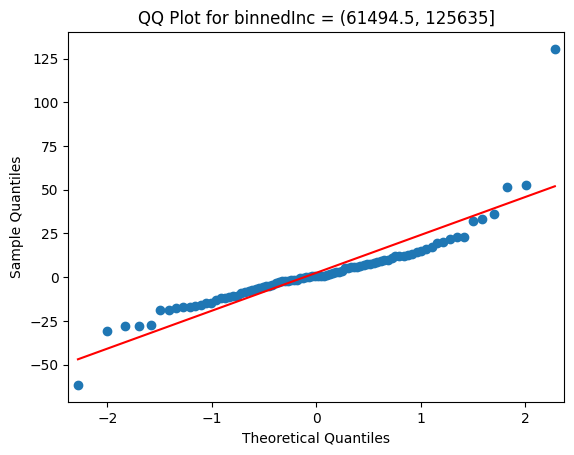

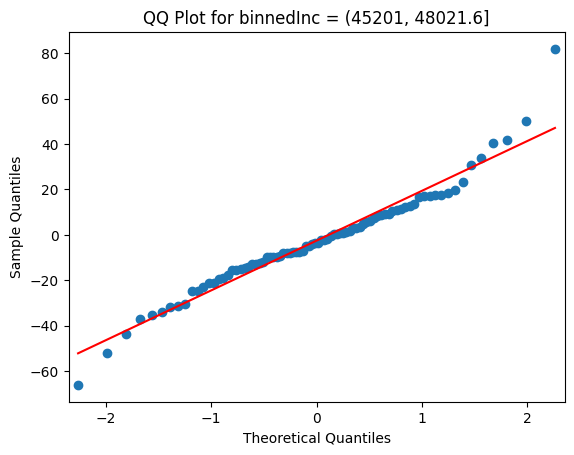

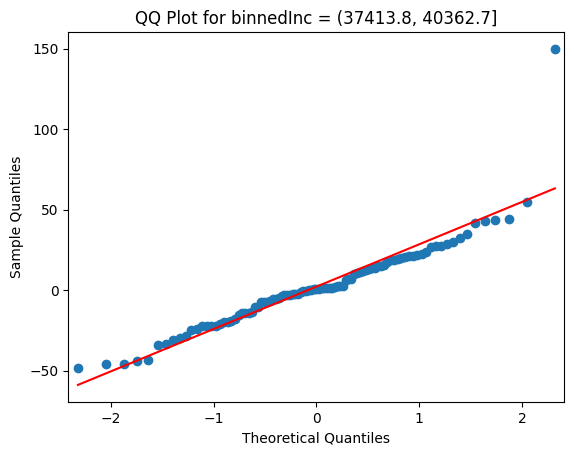

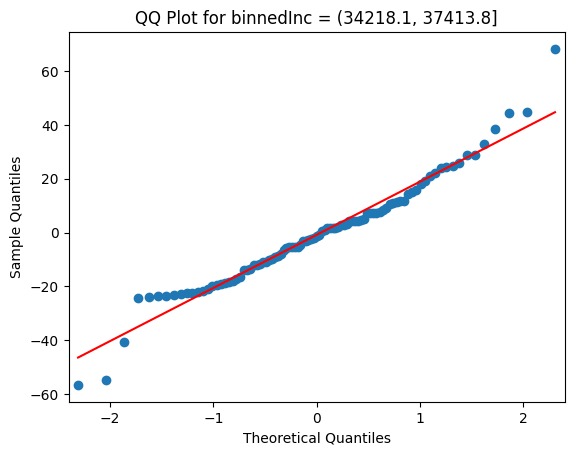

In [210]:
generate_qqplot_by_binned_inc(multi_models, df_test, filtered_features)

## RandomForest with Conformal Prediction

In [211]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True, max_depth=int(np.ceil(np.log2(len(df_train)) - 1)), min_samples_leaf=5)
rf.fit(df_train[filtered_features], df_train['TARGET_deathRate'])

,n_estimators,100
,criterion,'squared_error'
,max_depth,11
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [212]:
rf_y_pred = rf.predict(df_test[filtered_features])
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
rf_mse, rf_r2

(216.04559752624738, 0.7285535206643341)

In [213]:
feature_importances = pd.DataFrame(
            rf.feature_importances_,
            index=rf.feature_names_in_,
            columns=["importance"],
        ).sort_values("importance", ascending=False)

In [214]:
feature_importances

,importance
incidenceRate,0.275961
PctBachDeg25_Over,0.261507
avgAnnCount,0.244125
avgDeathsPerYear,0.096837
PctPrivateCoverage,0.028206
PctBlack,0.028106
PctPublicCoverage,0.027498
PctOtherRace,0.013482
medIncome,0.013030
PctAsian,0.011250


In [215]:
reg = ConformalizedRegressor(rf, alpha=0.05)

In [216]:
reg.fit(y=df_train[target], oob=True)

In [217]:
y_pred_intervals = reg.predict_interval(df_test[filtered_features])

In [218]:
y_pred = reg.predict(df_test[filtered_features])
reg.evaluate(df_test[filtered_features], df_test[target])

{'total': 906,
 'alpha': 0.05,
 'coverage_rate': 0.954,
 'interval_width_mean': 55.094,
 'mwis': 84.634,
 'mae': 9.809,
 'mbe': -0.979,
 'mse': 216.046}

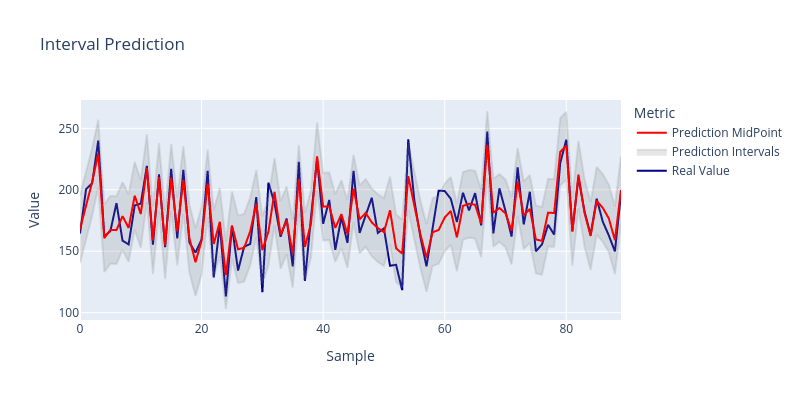

In [219]:
plot_prediction_intervals(y_pred_intervals[:90], y_pred[:90], y_test[:90], fig_type="png")